In [1]:
import networkx as nx
import numpy as np
import torch
import matplotlib.pyplot as plt
from extract_data import get_num_triangle_batched
from utils import construct_nx_from_adj
from extract_data import STATS
import tqdm
from graph_generator import generate_graph_node_triangles

2025-01-13 17:44:52.955794: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 17:44:52.957069: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 17:44:52.974736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 17:44:52.974752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 17:44:52.974778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

quick break at 581th iteration
nb triangles generated :  [tensor(3.), tensor(5.), tensor(5.), tensor(4.), tensor(4.)]


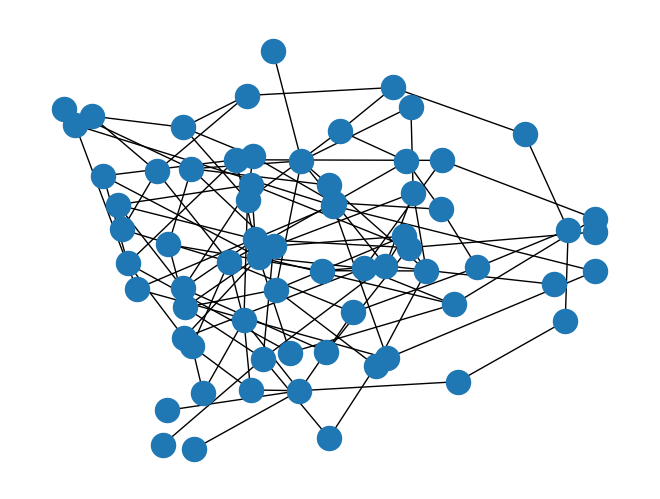

In [2]:
num_nodes = torch.Tensor([5,7,10,20,30])
nb_triangles = torch.Tensor([1,3,3,3,3])
proba_list = [1e-3]*3000

adjs = generate_graph_node_triangles(num_nodes, nb_triangles, proba_list)
print("nb triangles generated : ", list(get_num_triangle_batched(adjs)))
for adj in adjs:
    G = construct_nx_from_adj(adj.cpu().numpy())
    nx.draw(G)

In [3]:
from utils import preprocess_dataset


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_max_nodes=50
spectral_emb_dim=10
preprocess_function = preprocess_dataset
testset = preprocess_function("test", n_max_nodes, spectral_emb_dim)
stats = np.array(list(map(lambda x : x.stats[0], testset)))
nb_data = len(testset)
print(nb_data)
print(stats.shape)

Dataset ./data/dataset_test.pt loaded from file
1000
(1000, 7)


/home/antoine/Bureau/3A/altegrad/Conditional-Graph-Generation/src/utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)


In [4]:
print(list(zip(STATS, range(len(STATS)))))

[('node', 0), ('edge', 1), ('degre', 2), ('triangles', 3), ('g_cluster_coef', 4), ('max_k_core', 5), ('communities', 6)]


In [5]:
batch_size = 50
nb_batch = nb_data // batch_size
if nb_data % batch_size != 0:
    nb_batch += 1

stats_data_per_batch = [stats[batch_size*i: min(batch_size*(i+1), nb_data)] for i in range(nb_batch)]
num_nodes_batched = torch.Tensor(np.array(list(map(lambda x : x[:,0], stats_data_per_batch))))
num_triangles_batched = torch.Tensor(np.array(list(map(lambda x : x[:,3], stats_data_per_batch))))

In [32]:
adj_buffer = []
max_nb_nodes = torch.max(num_nodes_batched)
for num_nodes, num_triangles in tqdm.tqdm(list(zip(num_nodes_batched, num_triangles_batched))):
    adjs = generate_graph_node_triangles(num_nodes, num_triangles, proba_list, max_nb_nodes=max_nb_nodes)
    adj_buffer.append(adjs)
adj = torch.cat(adj_buffer, dim=0)

 35%|███▌      | 7/20 [00:14<00:24,  1.91s/it]

quick break at 1567th iteration


 70%|███████   | 14/20 [00:30<00:12,  2.00s/it]

quick break at 2007th iteration


 95%|█████████▌| 19/20 [00:40<00:01,  1.98s/it]

quick break at 1905th iteration


100%|██████████| 20/20 [00:42<00:00,  2.15s/it]


In [6]:
from utils import compute_normal_MAE
num_nodes_batched = num_nodes_batched.int().flatten()
print(adj.shape, num_nodes_batched.shape, stats.shape)

torch.Size([30, 30]) torch.Size([1000]) (1000, 7)


In [34]:
from extract_data import create_features
mae_per_component = (torch.Tensor(stats)-torch.stack(list(map(lambda x: create_features(*x), zip(adj, num_nodes_batched))))).abs().mean(dim=0)

In [35]:
mae_per_component

tensor([ 0.0000, 22.2760,  1.2390,  7.7580,  0.0770,  1.4490,  0.7040])

In [7]:
import csv
def save(adjs, name='baseline_output.csv'):
    with open(name, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        # Write the header
        writer.writerow(["graph_id", "edge_list"])
        
        
        for i in range(nb_data):
            data = testset[i]
            Gs_generated = construct_nx_from_adj(adjs[i].numpy())
            # Define a graph ID
            graph_ids = data.filename
        
            # Convert the edge list to a single string
            edge_list_text = ", ".join([f"({u}, {v})" for u, v in Gs_generated.edges()])
            # Write the graph ID and the full edge list as a single row
            writer.writerow([graph_ids, edge_list_text])
        
    

In [8]:
from graph_generator import GraphGenerator
from utils import MAE_reconstruction_loss_normalized
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
graphs = GraphGenerator(num_nodes_batched, device).to(device)
lr=1
nb_steps = 1200
optimizer = torch.optim.Adam(graphs.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=nb_steps,
                                                steps_per_epoch=1, pct_start=0.1, final_div_factor=1000)
pbar = tqdm.tqdm(range(nb_steps))
torch_stats = torch.from_numpy(stats).to(device)
num_nodes_batched_torch = num_nodes_batched.to(device)
lbd=1e-2
for _ in pbar:
    adjs = graphs.generate_graph()
    adjs = adjs.to(device)
    optimizer.zero_grad()
    loss_mae = MAE_reconstruction_loss_normalized(adjs, num_nodes_batched_torch, features_true=torch_stats) 
    #loss_diag =  adjs.diagonal(dim1=-2, dim2=-1).sum()
    #loss = loss_mae + lbd*loss_diag
    loss = loss_mae
    loss.backward()
    optimizer.step()
    scheduler.step()
    #pbar.set_description(f"loss_mae = {loss_mae.item():.3g}, loss_diag = {loss_diag.item():.3g}")
    pbar.set_description(f"loss_mae = {loss_mae.item():.3g}")
    
    

loss_mae = 0.131, loss_diag = 0: 100%|██████████| 1200/1200 [03:47<00:00,  5.28it/s]


In [9]:
adj = graphs.generate_graph().detach().cpu()
num_node_max = adj.shape[1]

# Mask the diagonal by setting diagonal elements to 0
adj[:, torch.arange(num_node_max), torch.arange(num_node_max)] = 0

In [10]:
from extract_data import create_features
mae_per_component = (torch.Tensor(stats)-torch.stack(list(map(lambda x: create_features(*x), zip(adj, num_nodes_batched))))).abs().mean(dim=0)

In [11]:
mae_total = mae_per_component.sum()
for name,val in zip(STATS, mae_per_component):
    print(name, "= ", val.item())
print(mae_total)

node =  0.0
edge =  5.355000019073486
degre =  0.3542168438434601
triangles =  36.34400177001953
g_cluster_coef =  0.013513828627765179
max_k_core =  0.7730000019073486
communities =  0.6819999814033508
tensor(43.5217)


In [12]:
save(adj, "trained_adj.csv")

In [13]:
for adj, num_nodes in zip(adjs, num_nodes_batched):
    print(num_nodes, adj[num_nodes:,num_nodes:].sum().item())

tensor(50, dtype=torch.int32) 0.0
tensor(20, dtype=torch.int32) 0.0
tensor(28, dtype=torch.int32) 0.0
tensor(47, dtype=torch.int32) 0.0
tensor(25, dtype=torch.int32) 0.0
tensor(31, dtype=torch.int32) 0.0
tensor(33, dtype=torch.int32) 0.0
tensor(15, dtype=torch.int32) 0.0
tensor(16, dtype=torch.int32) 0.0
tensor(20, dtype=torch.int32) 0.0
tensor(20, dtype=torch.int32) 0.0
tensor(41, dtype=torch.int32) 0.0
tensor(35, dtype=torch.int32) 0.0
tensor(30, dtype=torch.int32) 0.0
tensor(49, dtype=torch.int32) 0.0
tensor(10, dtype=torch.int32) 0.0
tensor(38, dtype=torch.int32) 0.0
tensor(19, dtype=torch.int32) 0.0
tensor(16, dtype=torch.int32) 0.0
tensor(48, dtype=torch.int32) 0.0
tensor(46, dtype=torch.int32) 0.0
tensor(46, dtype=torch.int32) 0.0
tensor(39, dtype=torch.int32) 0.0
tensor(12, dtype=torch.int32) 0.0
tensor(49, dtype=torch.int32) 0.0
tensor(43, dtype=torch.int32) 0.0
tensor(21, dtype=torch.int32) 0.0
tensor(29, dtype=torch.int32) 0.0
tensor(22, dtype=torch.int32) 0.0
tensor(44, dty